# Image segmentation

In [1]:
# !pip install -r requirements.txt

In [2]:
# !ipython kernel install --user --name=pix2pix

Select Kernal in jupyter notebook as 'pix2pix'

In [3]:
import tensorflow as tf

import tensorflow_datasets as tfds

In [4]:
from IPython.display import clear_output
import matplotlib.pyplot as plt
import cv2
from glob import glob
import os

In [5]:
im_ht, im_wd = 128, 128
model_ht, model_wd = 128, 128 #
IMAGE_SIZE = 128
BATCH_SIZE = 4
DATA_DIR = "dataset/dataXY/"
OUTPUT_CLASSES = 2

In [6]:
# wget https://www.dropbox.com/s/ej1gx48bxqbtwd2/CamVid.zip?dl=0 -O CamVid.zip
# unzip CamVid.zip
# if not os.path.isdir(DATA_DIR):
#     print("Error: DATA_DIR does not exist, clonign camvid from github")
#     os.system("git clone https://github.com/GeorgeSeif/Semantic-Segmentation-Suite.git")
#     DATA_DIR =  'Semantic-Segmentation-Suite/CamVid/'

In [7]:
NUM_TRAIN_IMAGES = 100
NUM_VAL_IMAGES = 20
continue_training = True

train_images = sorted(glob(os.path.join(DATA_DIR, "train/img//*")))[:NUM_TRAIN_IMAGES]
train_masks  = sorted(glob(os.path.join(DATA_DIR, "train/mask//*")))[:NUM_TRAIN_IMAGES]

val_images = sorted(glob(os.path.join(DATA_DIR, "val/img/*")))[:NUM_VAL_IMAGES]
val_masks  = sorted(glob(os.path.join(DATA_DIR, "val/mask/*")))[:NUM_VAL_IMAGES]
print(len(train_images),len(train_masks),len(val_images),len(val_masks))

30 30 6 6


In [8]:
#import pdb;pdb.set_trace()

def read_image(image_path, mask=False):
    image = tf.io.read_file(image_path)
    if mask:
        image = tf.image.decode_png(image, channels=1)
        image.set_shape([None, None, 1])
        image = tf.image.resize(images=image, size=[im_ht, im_wd])
    else:
        image = tf.image.decode_png(image, channels=3)
        image.set_shape([None, None, 3])
        image = tf.image.resize(images=image, size=[im_ht, im_wd])
    return image

def load_data(image_list, mask_list):
    image = read_image(image_list)
    mask = read_image(mask_list, mask=True)
    return image, mask

def normalize(input_image, input_mask):
    input_image = tf.cast(input_image, tf.float32) / 255.0
    return input_image, input_mask

def data_generator(image_list, mask_list):
    dataset = tf.data.Dataset.from_tensor_slices((image_list, mask_list))
    dataset = dataset.map(load_data, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.map(normalize, num_parallel_calls=tf.data.AUTOTUNE)
    return dataset

train_ds = data_generator(train_images, train_masks)
test_ds = data_generator(val_images, val_masks)

print("Train Dataset:", train_ds)
print("Val Dataset:", test_ds)

Train Dataset: <ParallelMapDataset element_spec=(TensorSpec(shape=(128, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(128, 128, 1), dtype=tf.float32, name=None))>
Val Dataset: <ParallelMapDataset element_spec=(TensorSpec(shape=(128, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(128, 128, 1), dtype=tf.float32, name=None))>


2022-03-13 23:22:57.130618: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-13 23:22:57.157031: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-13 23:22:57.158014: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-13 23:22:57.159600: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

The dataset already contains the required training and test splits, so continue to use the same splits.

In [9]:
TRAIN_LENGTH = len(train_images)
BATCH_SIZE = 3
BUFFER_SIZE = 1000
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE

The following class performs a simple augmentation by randomly-flipping an image.
Go to the [Image augmentation](data_augmentation.ipynb) tutorial to learn more.


In [10]:
def random_shift(images, labels):
    pass

In [11]:
central_frac = model_ht/im_ht
def center_crop(images, labels):
    images = tf.image.central_crop(images, central_fraction=central_frac)
    labels = tf.image.central_crop(labels, central_fraction=central_frac)
    return images, labels
    

In [12]:
def random_crop(images, labels):
    concat = tf.concat([images, labels], axis=-1)
    patches = tf.image.random_crop(concat, size=[-1, model_ht, model_wd, 4])
    patch_image = patches[:,:, :, :3]
    patch_mask = tf.expand_dims(patches[:,:, :, 3], axis=-1)

    return patch_image, patch_mask

In [13]:
class Augment(tf.keras.layers.Layer):
  def __init__(self, seed=42):
    super().__init__()
    seed = tf.random.uniform(shape=(1,), minval=1, maxval=1000000, dtype=tf.int32)
    rng = tf.random.Generator.from_seed(123, alg='philox')
    seed = rng.make_seeds(2)[0]
    # both use the same seed, so they'll make the same random changes.
    self.augment_inputs = tf.keras.layers.RandomFlip(mode="horizontal", seed=seed)
    self.augment_labels = tf.keras.layers.RandomFlip(mode="horizontal", seed=seed)
    
  
  def call(self, inputs, labels):
    inputs = self.augment_inputs(inputs)
    labels = self.augment_labels(labels)
    
    #seed = tf.random.uniform(shape=(2,), minval=1, maxval=1000000, dtype=tf.int32)
    #inputs = tf.image.stateless_random_crop(inputs, size=[model_ht, model_wd, 3], seed=seed)
    #labels = tf.image.stateless_random_crop(labels, size=[model_ht, model_wd, 1], seed=seed)
    return inputs, labels

Build the input pipeline, applying the Augmentation after batching the inputs.

In [14]:
train_batches = (
    train_ds
    .cache()
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE)
    .repeat()
    .map(Augment())
    #.map(center_crop)
    .prefetch(buffer_size=tf.data.AUTOTUNE))

test_batches = (
    test_ds
    .batch(BATCH_SIZE)
    #.map(center_crop)
)

Visualize an image example and its corresponding mask from the dataset.

In [15]:
def display(display_list):
  plt.figure(figsize=(15, 15))

  title = ['Input Image', 'True Mask', 'Predicted Mask']

  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(title[i])
    plt.imshow(tf.keras.utils.array_to_img(display_list[i]))
    plt.axis('off')
  plt.show()

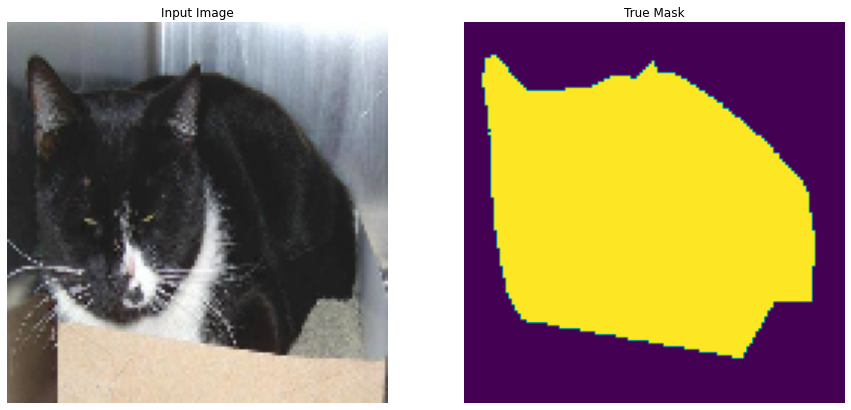

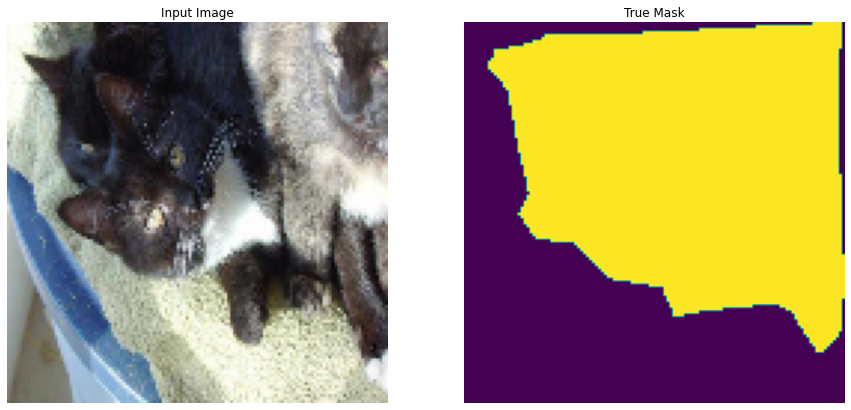

In [16]:
for images, masks in train_batches.take(2):
  sample_image, sample_mask = images[0], masks[0]
  display([sample_image, sample_mask])

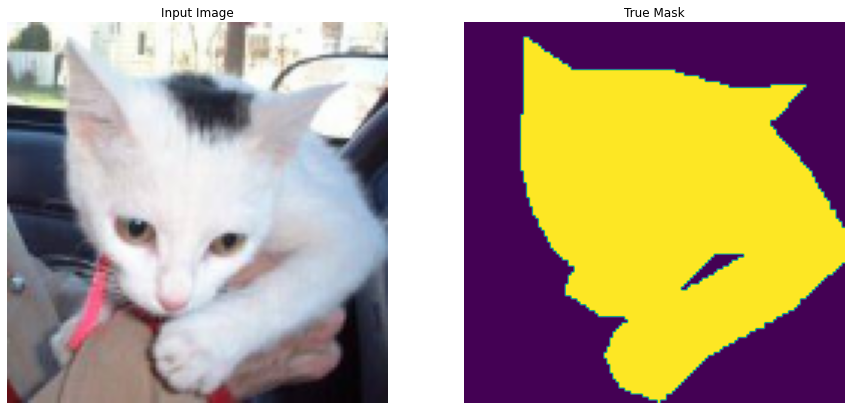

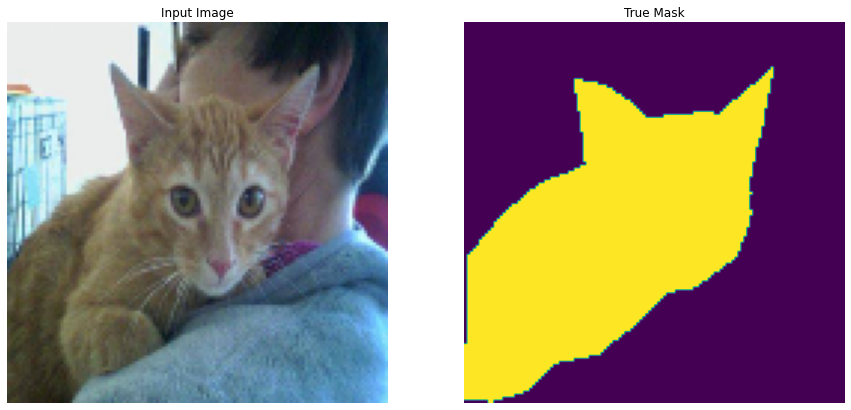

In [17]:
for images, masks in test_batches.take(2):
  sample_image, sample_mask = images[0], masks[0]
  display([sample_image, sample_mask])

## Define the model
The model being used here is a modified [U-Net](https://arxiv.org/abs/1505.04597). A U-Net consists of an encoder (downsampler) and decoder (upsampler). In-order to learn robust features and reduce the number of trainable parameters, you will use a pretrained model - MobileNetV2 - as the encoder. For the decoder, you will use the upsample block, which is already implemented in the [pix2pix](https://github.com/tensorflow/examples/blob/master/tensorflow_examples/models/pix2pix/pix2pix.py) example in the TensorFlow Examples repo. (Check out the [pix2pix: Image-to-image translation with a conditional GAN](../generative/pix2pix.ipynb) tutorial in a notebook.)


As mentioned, the encoder will be a pretrained MobileNetV2 model which is prepared and ready to use in `tf.keras.applications`. The encoder consists of specific outputs from intermediate layers in the model. Note that the encoder will not be trained during the training process.

In [18]:
def preprocess(x):
    #x = tf.cast(x, tf.float32)
    #x = tf.keras.applications.mobilenet_v2.preprocess_input(x)
    #x = x/255.0

    return x

In [19]:
def upsample(filters, size, norm_type='batchnorm', apply_dropout=False):
  """Upsamples an input.
  Conv2DTranspose => Batchnorm => Dropout => Relu
  """
  initializer = tf.random_normal_initializer(0., 0.02)

  result = tf.keras.Sequential()
  result.add(
      tf.keras.layers.Conv2DTranspose(filters, size, strides=2,
                                      padding='same',
                                      kernel_initializer=initializer,
                                      use_bias=False))

  if norm_type.lower() == 'batchnorm':
    result.add(tf.keras.layers.BatchNormalization())
  elif norm_type.lower() == 'instancenorm':
    result.add(InstanceNormalization())

  if apply_dropout:
    result.add(tf.keras.layers.Dropout(0.5))

  result.add(tf.keras.layers.ReLU())

  return result

In [20]:
base_model = tf.keras.applications.MobileNetV2(input_shape=[None, None, 3], include_top=False)

# Use the activations of these layers
layer_names = [
    'block_1_expand_relu',   # 64x64
    'block_3_expand_relu',   # 32x32
    'block_6_expand_relu',   # 16x16
    'block_13_expand_relu',  # 8x8
    'block_16_project',      # 4x4
]
base_model_outputs = [base_model.get_layer(name).output for name in layer_names]

# Create the feature extraction model
down_stack = tf.keras.Model(inputs=base_model.input, outputs=base_model_outputs)

down_stack.trainable = False

The decoder/upsampler is simply a series of upsample blocks implemented in TensorFlow examples.

In [21]:
up_stack = [
    upsample(512, 3),  # 4x4 -> 8x8
    upsample(256, 3),  # 8x8 -> 16x16
    upsample(128, 3),  # 16x16 -> 32x32
    upsample(64, 3),   # 32x32 -> 64x64
]

In [22]:
def unet_model(output_channels:int):
  inputs = tf.keras.layers.Input(shape=[None, None, 3])
  inputs = preprocess(inputs)

  # Downsampling through the model
  skips = down_stack(inputs)
  x = skips[-1]
  skips = reversed(skips[:-1])

  # Upsampling and establishing the skip connections
  for up, skip in zip(up_stack, skips):
    x = up(x)
    concat = tf.keras.layers.Concatenate()
    x = concat([x, skip])

  # This is the last layer of the model
  last = tf.keras.layers.Conv2DTranspose(
      filters=output_channels, kernel_size=3, strides=2,
      padding='same')  #64x64 -> 128x128

  x = last(x)

  return tf.keras.Model(inputs=inputs, outputs=x)

Note that the number of filters on the last layer is set to the number of `output_channels`. This will be one output channel per class.

## Train the model

Now, all that is left to do is to compile and train the model. 

Since this is a multiclass classification problem, use the `tf.keras.losses.CategoricalCrossentropy` loss function with the `from_logits` argument set to `True`, since the labels are scalar integers instead of vectors of scores for each pixel of every class. 

When running inference, the label assigned to the pixel is the channel with the highest value. This is what the `create_mask` function is doing.

In [23]:
OUTPUT_CLASSES = 3

model = unet_model(output_channels=OUTPUT_CLASSES)


model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [24]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 model (Functional)             [(None, None, None,  1841984     ['input_2[0][0]']                
                                 96),                                                             
                                 (None, None, None,                                               
                                 144),                                                            
                                 (None, None, None,                                         

Have a quick look at the resulting model architecture:

In [25]:
#tf.keras.utils.plot_model(model, show_shapes=True)

Try out the model to check what it predicts before training.

In [26]:
def create_mask(pred_mask):
  pred_mask = tf.argmax(pred_mask, axis=-1)
  pred_mask = pred_mask[..., tf.newaxis]
  return pred_mask[0]

In [27]:
def show_predictions(dataset=None, num=1):
  if dataset:
    for image, mask in dataset.take(num):
      pred_mask = model.predict(image)
      display([image[0], mask[0], create_mask(pred_mask)])
  else:
    display([sample_image, sample_mask,
             create_mask(model.predict(sample_image[tf.newaxis, ...]))])

2022-03-13 23:23:03.099741: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8201


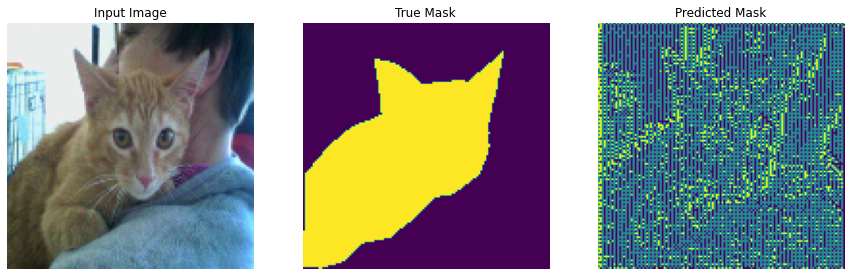

In [28]:
show_predictions()

The callback defined below is used to observe how the model improves while it is training.

In [29]:
class DisplayCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs=None):
    clear_output(wait=True)
    show_predictions()
    print ('\nSample Prediction after epoch {}\n'.format(epoch+1))

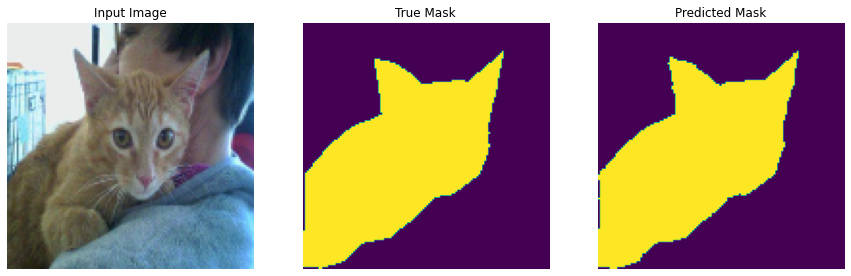


Sample Prediction after epoch 100

10/10 [==============================] - 0s 40ms/step - loss: 0.0116 - accuracy: 0.9958 - val_loss: 0.0132 - val_accuracy: 0.9949


In [30]:
EPOCHS = 100
VAL_SUBSPLITS = 1
VALIDATION_STEPS = len(val_images)//BATCH_SIZE//VAL_SUBSPLITS

model_history = model.fit(train_batches, epochs=EPOCHS,
                          steps_per_epoch=STEPS_PER_EPOCH,
                          validation_steps=VALIDATION_STEPS,
                          validation_data=test_batches,
                          callbacks=[DisplayCallback()])

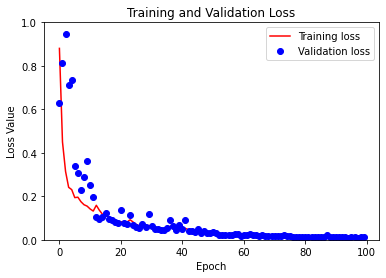

In [31]:
loss = model_history.history['loss']
val_loss = model_history.history['val_loss']

plt.figure()
plt.plot(model_history.epoch, loss, 'r', label='Training loss')
plt.plot(model_history.epoch, val_loss, 'bo', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.ylim([0, 1])
plt.legend()
plt.show()

## Make predictions

Now, make some predictions. In the interest of saving time, the number of epochs was kept small, but you may set this higher to achieve more accurate results.

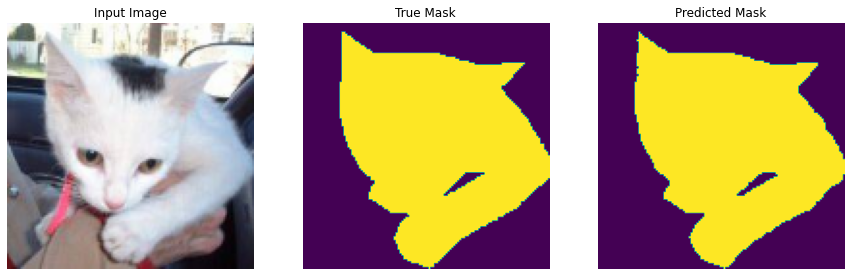

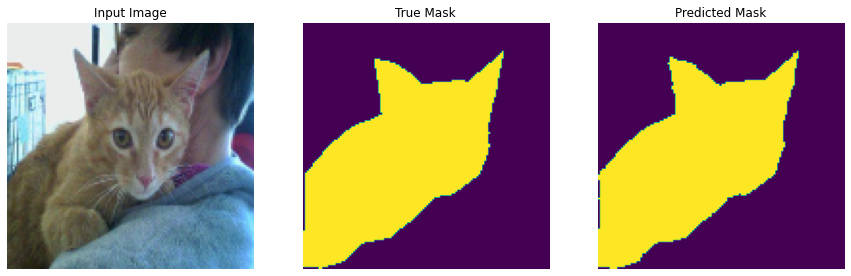

In [32]:
for images, masks in test_batches.take(2):
  sample_image, sample_mask = images[0], masks[0]
  display([sample_image, sample_mask, create_mask(model.predict(sample_image[tf.newaxis, ...]))])

In [33]:
sample_image.shape

TensorShape([128, 128, 3])

In [34]:
img = sample_image.numpy()
mask = sample_mask.numpy()
img.shape, mask.shape

((128, 128, 3), (128, 128, 1))

In [36]:
pred2 = model.predict(img[tf.newaxis, ...])
pred2.shape

(1, 128, 128, 3)

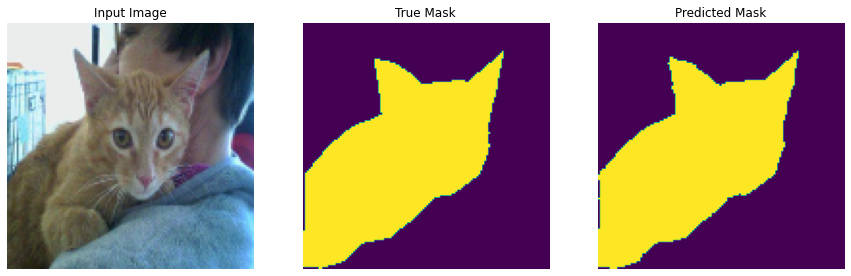

In [38]:
display([img, mask,
             create_mask(pred2)])

# Inference Example

In [39]:
image = tf.image.decode_png(tf.io.read_file('cat.jpg'))
image = tf.image.resize(images=image, size=[im_ht, im_wd])
image = tf.cast(image, tf.float32) / 255.0
pred_mask = model(image[tf.newaxis, ...])

pred_mask = tf.argmax(pred_mask, axis=-1)
pred_mask = pred_mask[..., tf.newaxis]
print(pred_mask[0].shape)
    

(128, 128, 1)


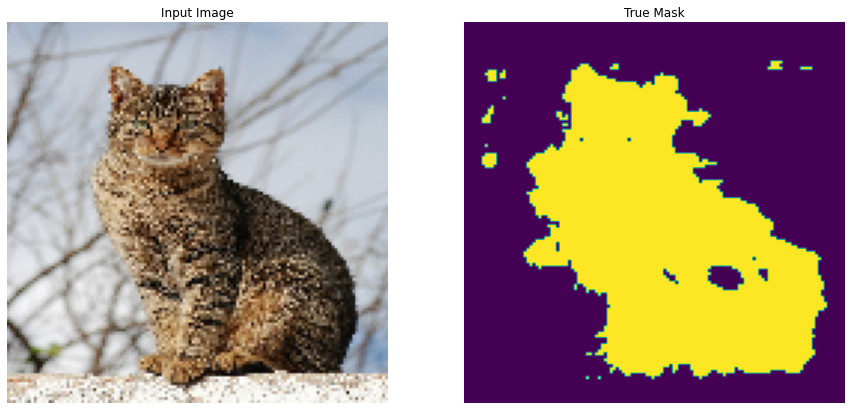

In [40]:
display([image, pred_mask[0]])